In [1]:
# Import required libraries
import warnings
warnings.filterwarnings('ignore')

import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import torch
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import shutil

In [2]:
# Set dataset path
dataset_path = 'TrashType_Image_Dataset'

# Get garbage types from folders
garbage_types = os.listdir(dataset_path)

In [ ]:
# Set untuk menyimpan dimensi gambar yang unik
all_dimensions_set = set()

# Iterasi untuk setiap jenis sampah dan periksa gambar
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)  # Path folder
    if os.path.isdir(folder_path):  # Cek jika folder
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        print(f"{garbage_type} folder contains {len(image_files)} images.")

        # Periksa dimensi tiap gambar
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                width, height = img.size
                channels = len(img.getbands())  # Hitung saluran warna
                all_dimensions_set.add((width, height, channels))

# Cek jika semua gambar memiliki dimensi yang sama
if len(all_dimensions_set) == 1:
    width, height, channel = all_dimensions_set.pop()
    print(f"\nSemua gambar memiliki dimensi yang sama: {width}x{height} dengan {channel} saluran warna.")
else:
    print("\nGambar-gambar memiliki dimensi atau saluran warna yang berbeda.")

cardboard folder contains 403 images.
glass folder contains 501 images.
metal folder contains 410 images.
paper folder contains 594 images.
plastic folder contains 482 images.
trash folder contains 137 images.

Semua gambar memiliki dimensi yang sama: 512x384 dengan 3 saluran warna.


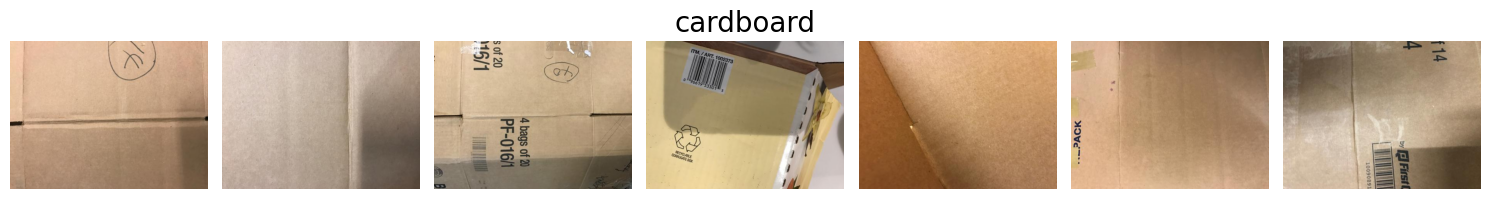

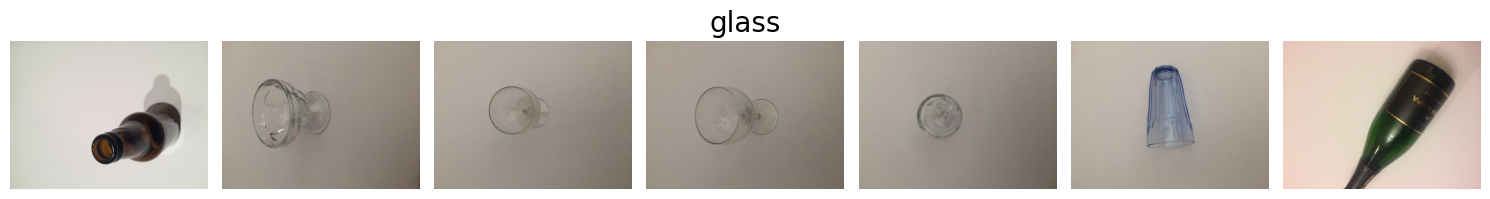

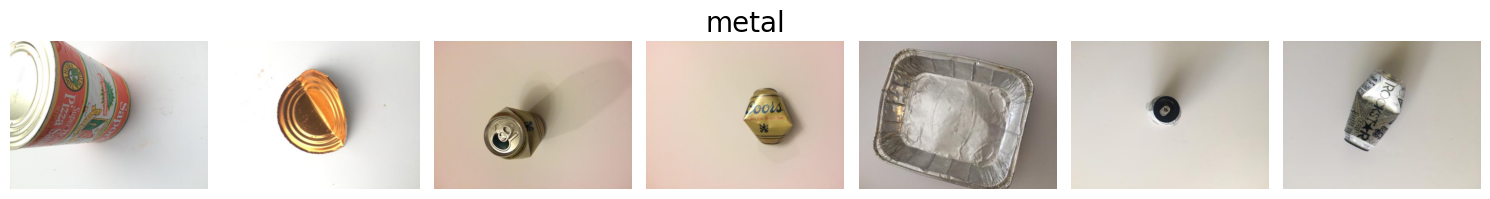

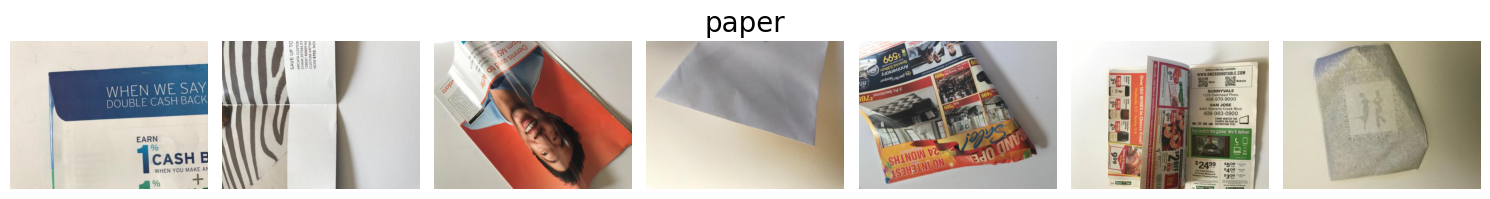

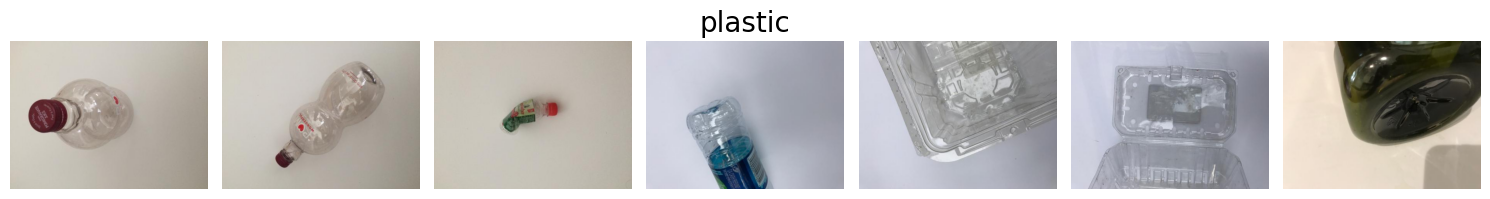

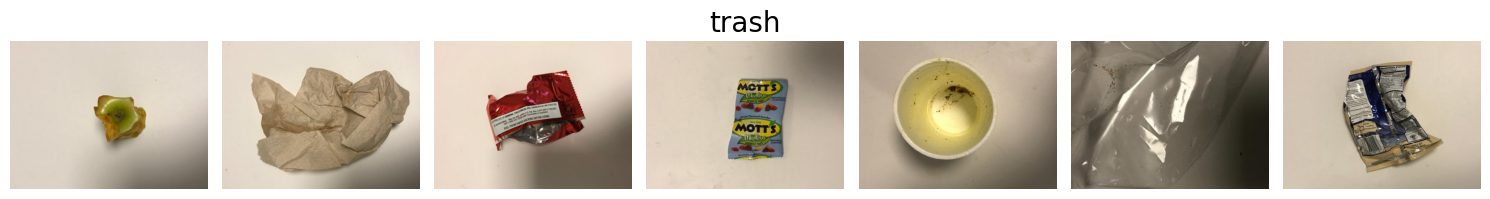

In [4]:
# Iterasi dan tampilkan 7 gambar pertama untuk setiap jenis sampah
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))][:7]

        # Tampilkan gambar-gambar dalam subplot
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))
        for i, image_file in enumerate(image_files):
            with Image.open(os.path.join(folder_path, image_file)) as img:
                axs[i].imshow(img)
                axs[i].axis('off')

        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()

In [5]:
# Inisialisasi list kosong untuk menyimpan jalur file gambar dan labelnya
data = []

# Loop melalui setiap jenis sampah dan kumpulkan jalur gambar beserta labelnya
for garbage_type in garbage_types:
    for file in os.listdir(os.path.join(dataset_path, garbage_type)):
        # Tambahkan jalur file gambar dan labelnya ke list data
        data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

# Ubah data yang terkumpul menjadi DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Tampilkan beberapa entri pertama dari DataFrame
df.head()

,filepath,label
0,TrashType_Image_Dataset\cardboard\cardboard_00...,cardboard
1,TrashType_Image_Dataset\cardboard\cardboard_00...,cardboard
2,TrashType_Image_Dataset\cardboard\cardboard_00...,cardboard
3,TrashType_Image_Dataset\cardboard\cardboard_00...,cardboard
4,TrashType_Image_Dataset\cardboard\cardboard_00...,cardboard


In [7]:
# Inisialisasi list untuk menyimpan data gambar dan label
data = []

# Loop untuk setiap jenis sampah dan buat file anotasi
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    if os.path.isdir(folder_path):  # Jika folder
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            # Tambahkan gambar dan label ke list data
            data.append((image_path, garbage_type))

            # Membuat file anotasi untuk YOLO
            label_file = os.path.join('./annotations', garbage_type, f"{os.path.splitext(image_file)[0]}.txt")
            os.makedirs(os.path.dirname(label_file), exist_ok=True)

            with open(label_file, 'w') as f:
                # Menghitung koordinat bounding box
                width, height = Image.open(image_path).size
                # Default values untuk bounding box
                x_center = 0.5
                y_center = 0.5
                box_width = 0.5
                box_height = 0.5

                # Mendapatkan ID kelas
                class_id = garbage_types.index(garbage_type)

                # Menulis ke file .txt sesuai format YOLO
                f.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")

In [8]:
# Mengonversi data menjadi DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Membagi dataset menjadi training dan validation set
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Menyimpan distribusi kelas
print("Class distribution in the entire dataset:\n")
print(df['label'].value_counts(normalize=True) * 100)

Class distribution in the entire dataset:

label
paper        23.506134
glass        19.825880
plastic      19.074001
metal        16.224772
cardboard    15.947764
trash         5.421448
Name: proportion, dtype: float64


In [9]:
def move_files(df, set_type):
    set_folder = f'./{set_type}'
    os.makedirs(os.path.join(set_folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(set_folder, 'labels'), exist_ok=True)

    for _, row in df.iterrows():
        image_file = row['filepath']
        label_file = os.path.join('./annotations', row['label'],
                                  f"{os.path.splitext(os.path.basename(image_file))[0]}.txt")

        # Pindahkan gambar dan label ke folder yang sesuai
        shutil.copy(image_file, os.path.join(set_folder, 'images', os.path.basename(image_file)))
        shutil.copy(label_file, os.path.join(set_folder, 'labels', os.path.basename(label_file)))


# Pindahkan file ke folder train dan val
move_files(train_df, 'train')
move_files(val_df, 'val')

def copy_trash_dataset(src_folder, dest_folder):
    """Copy TrashType_Image_Dataset to yolov5\TrashType_Image_Dataset."""
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    for item in os.listdir(src_folder):
        src_path = os.path.join(src_folder, item)
        dest_path = os.path.join(dest_folder, item)
        if os.path.isdir(src_path):
            shutil.copytree(src_path, dest_path, dirs_exist_ok=True)
        else:
            shutil.copy2(src_path, dest_path)
            
# Copy TrashType_Image_Dataset
copy_trash_dataset('TrashType_Image_Dataset', 'yolov5/TrashType_Image_Dataset')


In [12]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

# Install dependencies
!pip install -r requirements.txt

d:\Documents\Semester 7\Visi Komputer\finals\yolov5


fatal: destination path 'yolov5' already exists and is not an empty directory.


In [13]:
# Buat file YAML untuk konfigurasi dataset
yaml_content = """
train: ../train/images
val: ../val/images

# Jumlah kelas
nc: 6

# Nama kelas
names: ['paper', 'glass', 'plastic', 'metal', 'cardboard', 'trash']
"""

# Simpan file YAML
with open("dataset.yaml", "w") as file:
    file.write(yaml_content)-=

SyntaxError: invalid syntax (4285483925.py, line 15)

In [15]:
# Run training with optimized parameters
!python train.py --img 640 --batch 16 --epochs 10 --data dataset.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name yolo_trash_quick --noval                                                          

github: skipping check (offline), for updates see https://github.com/ultralytics/yolov5


train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=dataset.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=True, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=yolo_trash_quick, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
fatal: cannot change to 'D:\Documents\Semester': No such file or directory
YOLOv5  2024-12-21 Python-3.12.0 torch-2.5.1+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=

Using cache found in C:\Users\USER/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-12-21 Python-3.12.0 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
C:\Users\USER/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 533x800 7 metals
Speed: 6.0ms pre-process, 73.6ms inference, 1.0ms NMS per image at shape (1, 3, 448, 640)


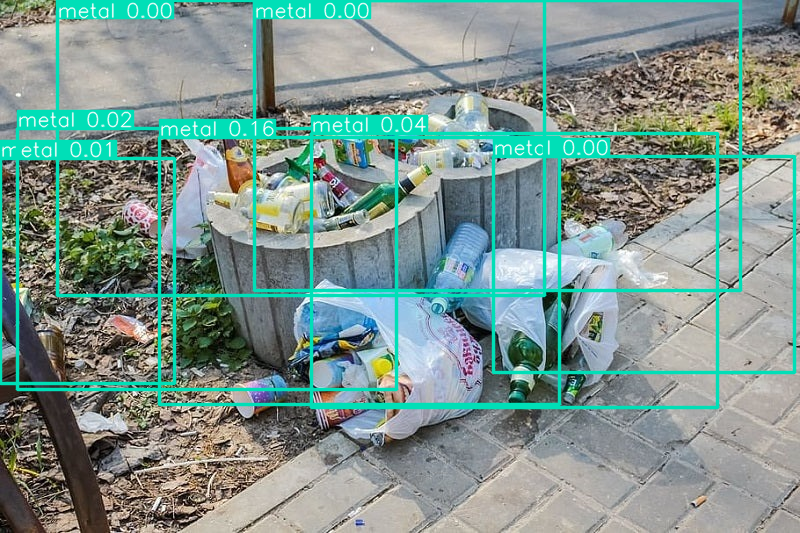

tensor([[1.59252e+02, 1.37306e+02, 5.59506e+02, 4.04593e+02, 1.62008e-01, 3.00000e+00],
        [3.11672e+02, 1.33182e+02, 7.17710e+02, 4.07234e+02, 3.53452e-02, 3.00000e+00],
        [1.70073e+01, 1.28368e+02, 3.96325e+02, 3.89710e+02, 1.71586e-02, 3.00000e+00],
        [0.00000e+00, 1.58535e+02, 1.74652e+02, 3.83629e+02, 5.31885e-03, 3.00000e+00],
        [5.74441e+01, 0.00000e+00, 5.44340e+02, 2.95219e+02, 2.14408e-03, 3.00000e+00],
        [4.93998e+02, 1.56256e+02, 7.94764e+02, 3.72945e+02, 1.89949e-03, 3.00000e+00],
        [2.54623e+02, 0.00000e+00, 7.40150e+02, 2.90259e+02, 1.31760e-03, 3.00000e+00]])


In [18]:
import os
from PIL import Image
import torch

def test_model(model_path, test_image_path):
    # Load model
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)

    # Set confidence threshold
    model.conf = 0.001  # Set confidence threshold to 0.1

    # Load image
    img = Image.open(test_image_path)

    # Inference
    results = model(img)

    # Display results
    results.print()
    results.show()

    # Lihat hasil prediksi mentah
    print(results.xyxy[0])  # Koordinat bounding box, confidence score, dan class ID

    # Jika kosong, tampilkan pesan
    if len(results.xyxy[0]) == 0:
        print("No objects detected. Check model or input image.")

test_image_path = 'a.jpg'  # Your sample image paths
model_path = 'runs/train/yolo_trash_quick2/weights/best.pt'
test_model(model_path, test_image_path)

In [20]:
import subprocess

# Define paths
yolov5_path = "yolov5"  # Adjust this if your YOLOv5 folder is in a different location
weights_path = 'runs/train/yolo_trash_quick2/weights/best.pt'  # Path to your trained weights
data_yaml_path = "data/dataset.yaml"  # Path to your dataset YAML file

# Run val.py
result = subprocess.run(
    [
        "python", "val.py",
        "--weights", weights_path,
        "--data", data_yaml_path,
        "--img", "640"  # Image size
    ],
    capture_output=True, text=True, encoding='utf-8', errors='ignore'
)

# Print output logs
print(result.stdout)
print(result.stderr)



val: data=data/dataset.yaml, weights=['runs/train/yolo_trash_quick2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=exp, exist_ok=False, half=False, dnn=False
fatal: cannot change to 'D:\Documents\Semester': No such file or directory
YOLOv5  2024-12-21 Python-3.12.0 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs

val: Scanning D:\Documents\Semester 7\Visi Komputer\finals\val\labels.cache... 506 images, 0 backgrounds, 0 corrupt: 100%|██████████| 506/506 [00:00<?, ?it/s]
val: Scanning D:\Documents\Semester 7\Visi Komputer\finals\val\labels.cache... 506 images, 0 backgrounds, 0 corrupt: 100%|██████████| 506/506 [00:00<?, ?it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-